# External stabilization

<H2>Current shot </H2>
<center>
<iframe src='icon.html' width=1300 height=550 ></iframe>
<center>

<H2>Scan </H2>
<center>
<iframe src='scan.html' width=900 height=800 ></iframe>
<center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy import integrate, signal, interpolate
import pandas as pd
import os, glob
ds = np.DataSource()

def remove_old(name):
    if os.path.exists(name):
        os.remove(name)
        
names = ['analysis.html', 'scan.html', 'icon.html', 'icon-fig.png','icon-fig_Radial.png','icon-fig_Vertical.png','IexStab.png']
for name in names:
    remove_old(name)
    
if os.path.exists('Results/'):
    file=glob.glob('Results/*')
    for f in file:
        os.remove(f)

In [2]:
shot_no=0
def open_remote(shot_no, identifier, url_template):
    return ds.open(url_template.format(shot_no=shot_no, identifier=identifier))

def read_signal(shot_no, identifier, url, data_type='csv'): 
    file = open_remote(shot_no, identifier, url)
    if data_type == 'lvm':
        channels = channels = ['Time', 'mc1','mc5','mc9','mc13','Saddle','InnerQuadr', 'mc_out','IexStab','9', '10', '11', '12']
        return pd.read_table(file, sep = '\t', names=channels)
    else:
        return pd.read_csv(file, names=['Time', identifier],
                     index_col = 'Time', squeeze=True)
def remove_offset(data, window):
    data-=data.loc[:window].mean()
    return data

def smooth(data,win=41):
    smooth_data = signal.savgol_filter(data, win, 3)
    return smooth_data

url = f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/LimiterMirnovCoils/plasma_position.csv'
kI=1/0.05 #Rogowski coil (Flux loop) constant

try:
    tab=ds.open(url)
    df=pd.read_csv(tab)
    end=df['Time'].iat[-1]
    start=df['Time'].iat[0]
    df=df.set_index('Time')
    mirnov=True
except OSError:
    mirnov=False
    
try:
    
    url_U_rad  = f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Operation/Discharge/Stabilization/DAS_raw_data_dir_radial/U%5eradial_fg.csv'
    url_I_rad  = f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Operation/Discharge/Stabilization/DAS_raw_data_dir_radial/U%5eradial_currclamp.csv'

    url_U_vert  = f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Operation/Discharge/Stabilization/DAS_raw_data_dir_vertical/U%5evertical_fg.csv'
    url_I_vert  = f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Operation/Discharge/Stabilization/DAS_raw_data_dir_vertical/U%5evertical_currclamp.csv'
    
    U_exStabVert = read_signal(shot_no, 'U_fg_Vert', url_U_vert)
    
    dt = 2 #time scale setting on the oscilloscope (...ms per window)
    t_osc = pd.Series(np.linspace(0,dt*10, len(U_exStabVert))).rename('Time')
    U_exStabVert = pd.Series(U_exStabVert.index[:], index = t_osc)
    RogCoilVert = read_signal(shot_no, 'I_fg_Vert', url_I_vert)
    I_exStabVert = pd.Series(smooth(RogCoilVert.index[:]*kI), index = t_osc) #the data was multiplied by the consntant [V->A]
#     I_exStabVert = pd.Series(smooth(RogCoilVert.index[:]), index = t_osc) #the data is already recalculated
         
    U_exStabRad = read_signal(shot_no, 'U_fg_Rad', url_U_rad)
    
    dt = 2 #time scale setting on the oscilloscope (...ms per window)
    t_osc = pd.Series(np.linspace(0,dt*10, len(U_exStabRad))).rename('Time')
    U_exStabRad = pd.Series(U_exStabVert.index[:], index = t_osc)
    RogCoilRad = read_signal(shot_no, 'I_fg_Rad', url_I_rad)
    I_exStabRad = pd.Series(smooth(RogCoilRad.index[:]*kI), index = t_osc) #the data was multiplied by the consntant [V->A]
#     I_exStabRad = pd.Series(smooth(RogCoilRad.index[:]), index = t_osc) #the data is already recalculated
        
    exStab=True
    
except OSError:
    
    exStab=False

print(f'External Stabilization:{exStab}')


External Stabilization:True


### Stabilization

Maximum current: 10.92 A
Maximum current: 10.59 A


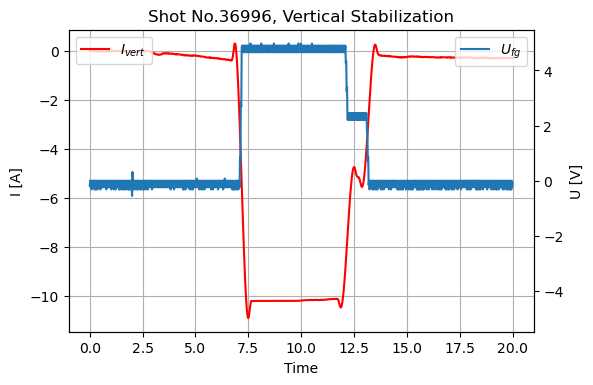

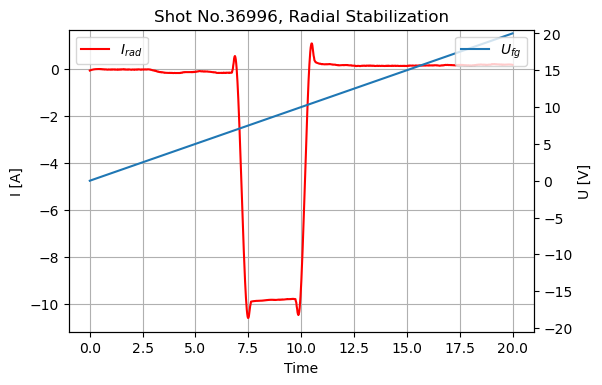

In [3]:
names=['$I_{vert}$','$I_{rad}$','$U_{vert}$','$U_{rad}$','Vertical', 'Radial']
Stab=pd.DataFrame({'$I_{vert}$': I_exStabVert, '$I_{rad}$': I_exStabRad, 
                   '$U_{vert}$': U_exStabVert, '$U_{rad}$': U_exStabRad})
maxI=0
for stab in range(2):
    I=names[stab]
    U=names[stab+2]

    fig, ax = plt.subplots(dpi=100)
    ax = Stab[I].plot(grid=True,label = I, c = 'r') #ocilloscope data
    ax2 = ax.twinx()
    ax2 = Stab[U].plot(label = '$U_{fg}$',c='tab:blue')
    ax.legend(loc='upper left')
    ax.set_ylabel('I [A]')
    ax.set_ylim= (-max(abs(Stab[I]))-0.5, max(abs(Stab[I]))+0.5)
    ax2.legend(loc='upper right')
    ax2.set_ylabel('U [V]')
    ax2.set_ylim(-max(abs(Stab[U]))-0.5, max(abs(Stab[U]))+0.5)
    ax.set_title(f'Shot No.{shot_no}, {names[stab+4]} Stabilization')
    if mirnov==True:
        plt.savefig('icon-fig_'+names[stab+4]+'.png')
    else:
        plt.savefig('icon-fig.png')
    #     maxI=max(abs(IexStab_cut)) #use with NI
    maxI_stab=max(abs(Stab[I]))
    if maxI<maxI_stab:
        maxI=maxI_stab
    print('Maximum current:', round(maxI_stab,2), 'A')

    with open('Results/MaxI_'+names[stab+4], 'w') as f:
        f.write(str(round(maxI_stab,2)))

In [4]:
df_processed = pd.concat([Stab], axis='columns')
df_processed

$I_{vert}$  $I_{rad}$  $U_{vert}$  $U_{rad}$
Time                                                  
0.00000    -0.009748  -0.081276   -0.158077    0.00000
0.02002    -0.010382  -0.073859    0.000000    0.02002
0.04004    -0.011191  -0.067030   -0.237116    0.04004
0.06006    -0.012159  -0.060770    0.000000    0.06006
0.08008    -0.013268  -0.055056   -0.316154    0.08008
...              ...        ...         ...        ...
19.91992   -0.297893   0.172182    0.000000   19.91992
19.93994   -0.298348   0.170097   -0.316154   19.93994
19.95996   -0.299017   0.167491    0.000000   19.95996
19.97998   -0.299918   0.164325   -0.237116   19.97998
20.00000   -0.301069   0.160564   -0.079039   20.00000

[1000 rows x 4 columns]

In [5]:
if exStab and mirnov:
    Stab_cut=Stab.loc[start:end]
    df_processed = pd.concat([df, Stab_cut],axis='columns')
    
    #replace NaN value
    k_I = 0
    k_U = 0

    for stab in range(2):
        I=names[stab]
        U=names[stab+2]
        
        for i in range(len(df_processed[I])):
            if not np.isnan(df_processed[I].iat[i]):
                k_I = df_processed[I].iat[i]
                k_U = df_processed[U].iat[i]

        else:
            df_processed[I].iat[i]=k_I
            df_processed[U].iat[i]=k_U
            
elif mirnov:
    df_processed = df

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
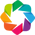

False


In [6]:
import holoviews as hv
hv.extension('bokeh')
import hvplot.pandas
print(mirnov)
if mirnov:
    hline = hv.HLine(0)
    hline.opts(color='k', line_dash='dashed', alpha = 0.4, line_width=1.0)
    I_v=names[0]
    I_r=names[1]
    if exStab: 
        ax_param=dict(ylim=(-85, 85),height=250,width=600, grid = True)
        axIvert_param=dict(title = '',ylabel='I_exStab [A]', xlabel='Time [ms]', yaxis='left', height=250, width=600, 
             color='b', ylim=(-maxI-1.5, maxI+1.5),grid=True)

        axIrad_param=dict(title = '',ylabel='I_exStab [A]', xlabel='Time [ms]', yaxis='left', height=250, width=600, 
             color='r', ylim=(-maxI-1.5,maxI+1.5),grid=True)

        
        plot = df_processed['r'].hvplot(title = '', ylabel='r [mm]/ I[A]', xlabel='', **ax_param) *\
                    df_processed[I_v].hvplot(**axIvert_param) *\
                        df_processed[I_r].hvplot(**axIrad_param)+\
        df_processed['z'].hvplot(title = '',ylabel='z [mm] / I[A]',  xlabel='Time [ms]', **ax_param) *\
            df_processed[I_v].hvplot(**axIvert_param) *\
                df_processed[I_r].hvplot(**axIrad_param)+\
        df_processed['a'].hvplot(title = '',ylabel='a[mm]/ I[A]', xlabel='Time [ms]', **ax_param) *\
            df_processed[I_v].hvplot(**axIvert_param) *\
                    df_processed[I_r].hvplot(**axIrad_param)
        plot=plot*hline
        plot.cols(2)
    else:
        layout = hv.Layout([df_processed[v].hvplot.line(
            xlabel='', ylabel=l,ylim=(-85,85), xlim=(start,end),legend=False, title='', grid=True, group_label=v)
                            for (v, l) in [('r', ' r [mm]'), ('z', 'z [mm]'), ('a', 'a [mm]')] ])*hline
        plot=layout.cols(1).opts(hv.opts.Curve(width=600, height=200),  hv.opts.Curve('a', xlabel='time [ms]'))

    hvplot.save(plot, 'icon.html')
# plot

In [7]:
data_URL = f"http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/LimiterMirnovCoils/DAS_raw_data_dir/NIdata_6133.lvm"
Irog = read_signal(shot_no, 'IexStab', data_URL, 'lvm')
Irog = Irog.set_index('Time')
Irog = Irog.replace([np.inf, -np.inf, np.nan], value = 0)
Irog_smooth = smooth(Irog['IexStab']*kI,21)
Irog=pd.Series(Irog_smooth,Irog.index*1e3)
# ax=Irog.plot()

## Scan over the session

In [8]:
try:
    ScanDef_url = requests.get("http://golem.fjfi.cvut.cz/shots/%i/Production/Parameters/ScanDefinition" % shot_no)
    ScanDef = ScanDef_url.text
    ScanDef=ScanDef.split(" ")
#     print(ScanDef)
#     ScanDef=ScanDef.split(",")
    for i in range(len(ScanDef)):
        ScanDef[i]=int(ScanDef[i])
    Scan=True
except ValueError:
    Scan=False
    ScanDef=[]
    print('Scan not defined')

Scan not defined


In [9]:
if Scan and mirnov:
    for shot in ScanDef:
        url='http://golem.fjfi.cvut.cz/shots/%i/Diagnostics/LimiterMirnovCoils/plasma_position.csv'%shot
        tab=ds.open(url)
        df2=pd.read_csv(tab)
        end=df2['Time'].iat[-1]
        start=df2['Time'].iat[0]
        df2=df2.set_index('Time')
        param = ['r','z', 'a']
        for j in param:
            df2_rename=df2[j].rename(j+'_%i'%shot)
            df_processed = pd.concat([df_processed, df2_rename], axis='columns')
            
    ax_param=dict(ylim=(-85, 85),height=250,width=600, grid = True)
    hline = hv.HLine(0)
    hline.opts(color='k', line_dash='dashed', alpha = 0.4, line_width=1.0)
    
    plotScan = df_processed['r'].hvplot(title = '', ylabel='r [mm]', xlabel='', **ax_param) +\
        df_processed['z'].hvplot(title = '',ylabel='z [mm]',  xlabel='', **ax_param) +\
        df_processed['a'].hvplot(title = '',ylabel='a[mm]', xlabel='Time [ms]', **ax_param)

    for shot in ScanDef:
        plotScan=plotScan[0]*df_processed['r_%i'%shot].hvplot(title = '', ylabel='r [mm]', xlabel='', **ax_param)+\
            plotScan[1]*df_processed['z_%i'%shot].hvplot(title = '', ylabel='z [mm]', xlabel='', **ax_param)+\
            plotScan[2]*df_processed['a_%i'%shot].hvplot(title = '', ylabel='a [mm]', xlabel='Time', **ax_param)  
        plotScan=plotScan*hline
        plotScan.cols(1)
        hvplot.save(plotScan, 'scan.html')


In [10]:
def scan():
    tdur=[]
    StabParam=[]
    MaxIvertStab=[]
    MaxIradStab=[]
    ScanDef.append(shot_no)
    for shot in ScanDef:
        url_tdur=requests.get('http://golem.fjfi.cvut.cz/shots/%i/Diagnostics/BasicDiagnostics/Results/t_plasma_duration'%shot)
        tdur.append(float(url_tdur.text))

        url_StabVert=requests.get('http://golem.fjfi.cvut.cz/shots/%i/Production/Parameters/infrastructure.vertical_stabilization'%shot)
        StabVertParam.append(url_StabVert.text) 
        url_StabRad=requests.get('http://golem.fjfi.cvut.cz/shots/%i/Production/Parameters/infrastructure.radial_stabilization'%shot)
        StabRadParam.append(url_StabRad.text) 
        
        url_maxIvert=requests.get('http://golem.fjfi.cvut.cz/shots/%i/Operation/Discharge/Stabilization/Results/MaxI_Vertical'%shot)
        MaxIvertStab.append(url_maxIvert.text)
        url_maxIrad=requests.get('http://golem.fjfi.cvut.cz/shots/%i/Operation/Discharge/Stabilization/Results/MaxI_Radial'%shot)
        MaxIradStab.append(url_maxIrad.text)
    data={'Plasma duration': tdur, 'Vertical Stabilization parameters': StabVertParam, 
            'Radial Stabilization parameters': StabRadParam, 'Max current in VertStab': MaxIvertStab,
              'Max current in RadStab': MaxIradStab, 'Shot_no': ScanDef}
    df_results=pd.DataFrame(data)
    df_results=df_results.set_index('Shot_no')
    return df_results

if mirnov and scan:
    display(scan())

### New iconfig

In [11]:
if mirnov:
    fig, axs = plt.subplots(3, 1, sharex=True, dpi=200)
    df_processed['r'].plot(grid=True, ax=axs[0])
    df_processed['z'].plot(grid=True, ax=axs[1])
    df_processed['a'].plot(grid=True, ax=axs[2])
    for i in range(3):
        ax4=axs[i].twinx()
        ax4=df_processed[names[0]].plot(grid=True, c='b',label=names[0])
        ax4=df_processed[names[1]].plot(grid=True, c='r',label=names[1])
        plt.legend()
        ax4.set(xlim=(start,end), ylim=(-maxI,maxI),xlabel= 'Time [ms]', ylabel = 'IexStab [A]')
        
    axs[2].set(ylim=(-85,85), xlim=(start,end), xlabel= 'Time [ms]', ylabel = '$a$ [mm]')
    axs[1].set(ylim=(-85,85), xlim=(start,end), xlabel= 'Time [ms]', ylabel = '$\Delta$z [mm]')
    axs[0].set(ylim=(-85,85), xlim=(start,end), xlabel= 'Time [ms]', ylabel = '$\Delta$r [mm]', 
               title = 'Horizontal, vertical plasma position and radius #{}'.format(shot_no))
    plt.savefig('icon-fig')